# Evaluation and Comparison of Features

In this notebook we explore the impact of existing features on target in a comparison to new features.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
data = pd.read_csv("../data/processed/pop_cat_train_new_feature_cleaned.csv") 
df = data.copy()
df.shape

(59400, 24)

In [34]:
categorical_columns = [
   'subvillage','lga','ward', 'basin','management_group','payment_type','source_class', 'waterpoint_type'
] # 'funder_grouped', 'installer_grouped', 'extraction_type_group','extraction_type_class','source_type',

for column in categorical_columns:
    df[column], _ = pd.factorize(df[column])

In [27]:
# Map the categorical values to numerical values
status_mapping = {'functional': 1, 'non functional': 0, 'functional needs repair': 2}
df['status_group'] = df['status_group'].map(status_mapping)

# Calculate the correlation matrix
correlation_matrix = df.select_dtypes(include='number').corr()

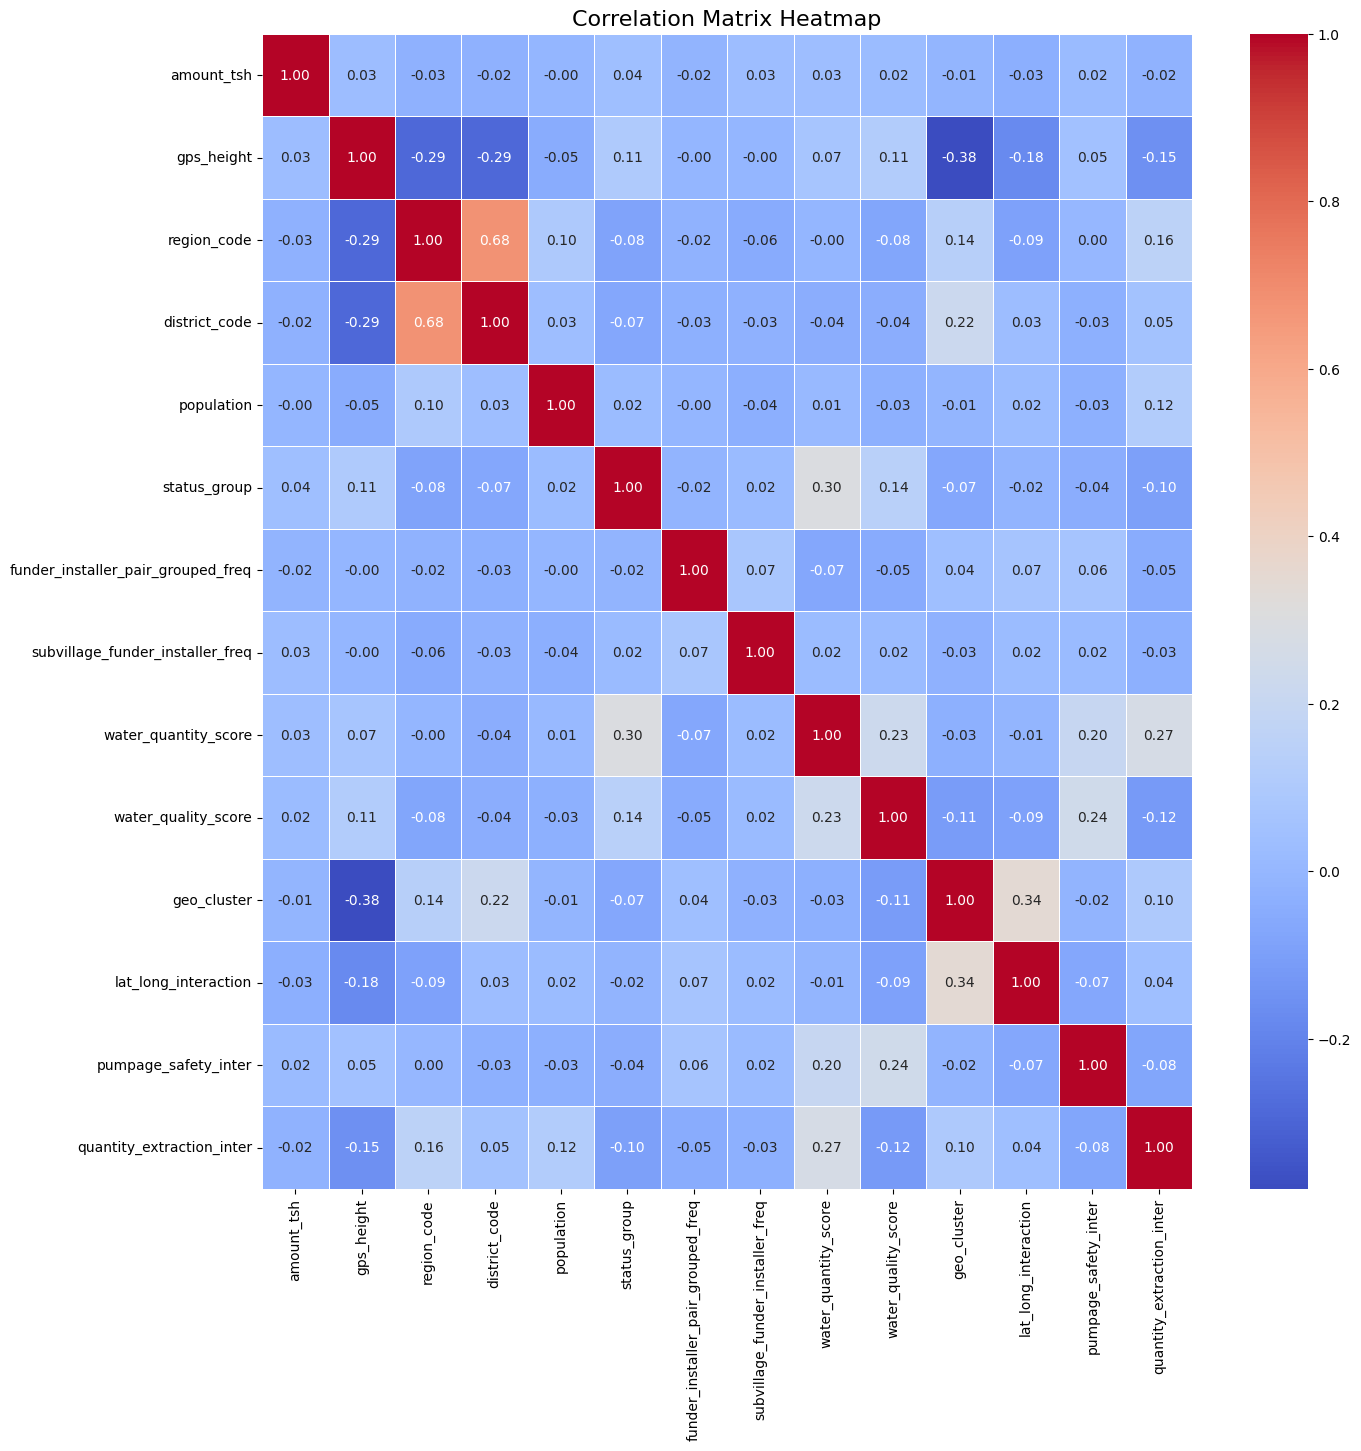

In [28]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 15))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Correlation Matrix Heatmap", fontsize=16)

# Show the plot
plt.show()

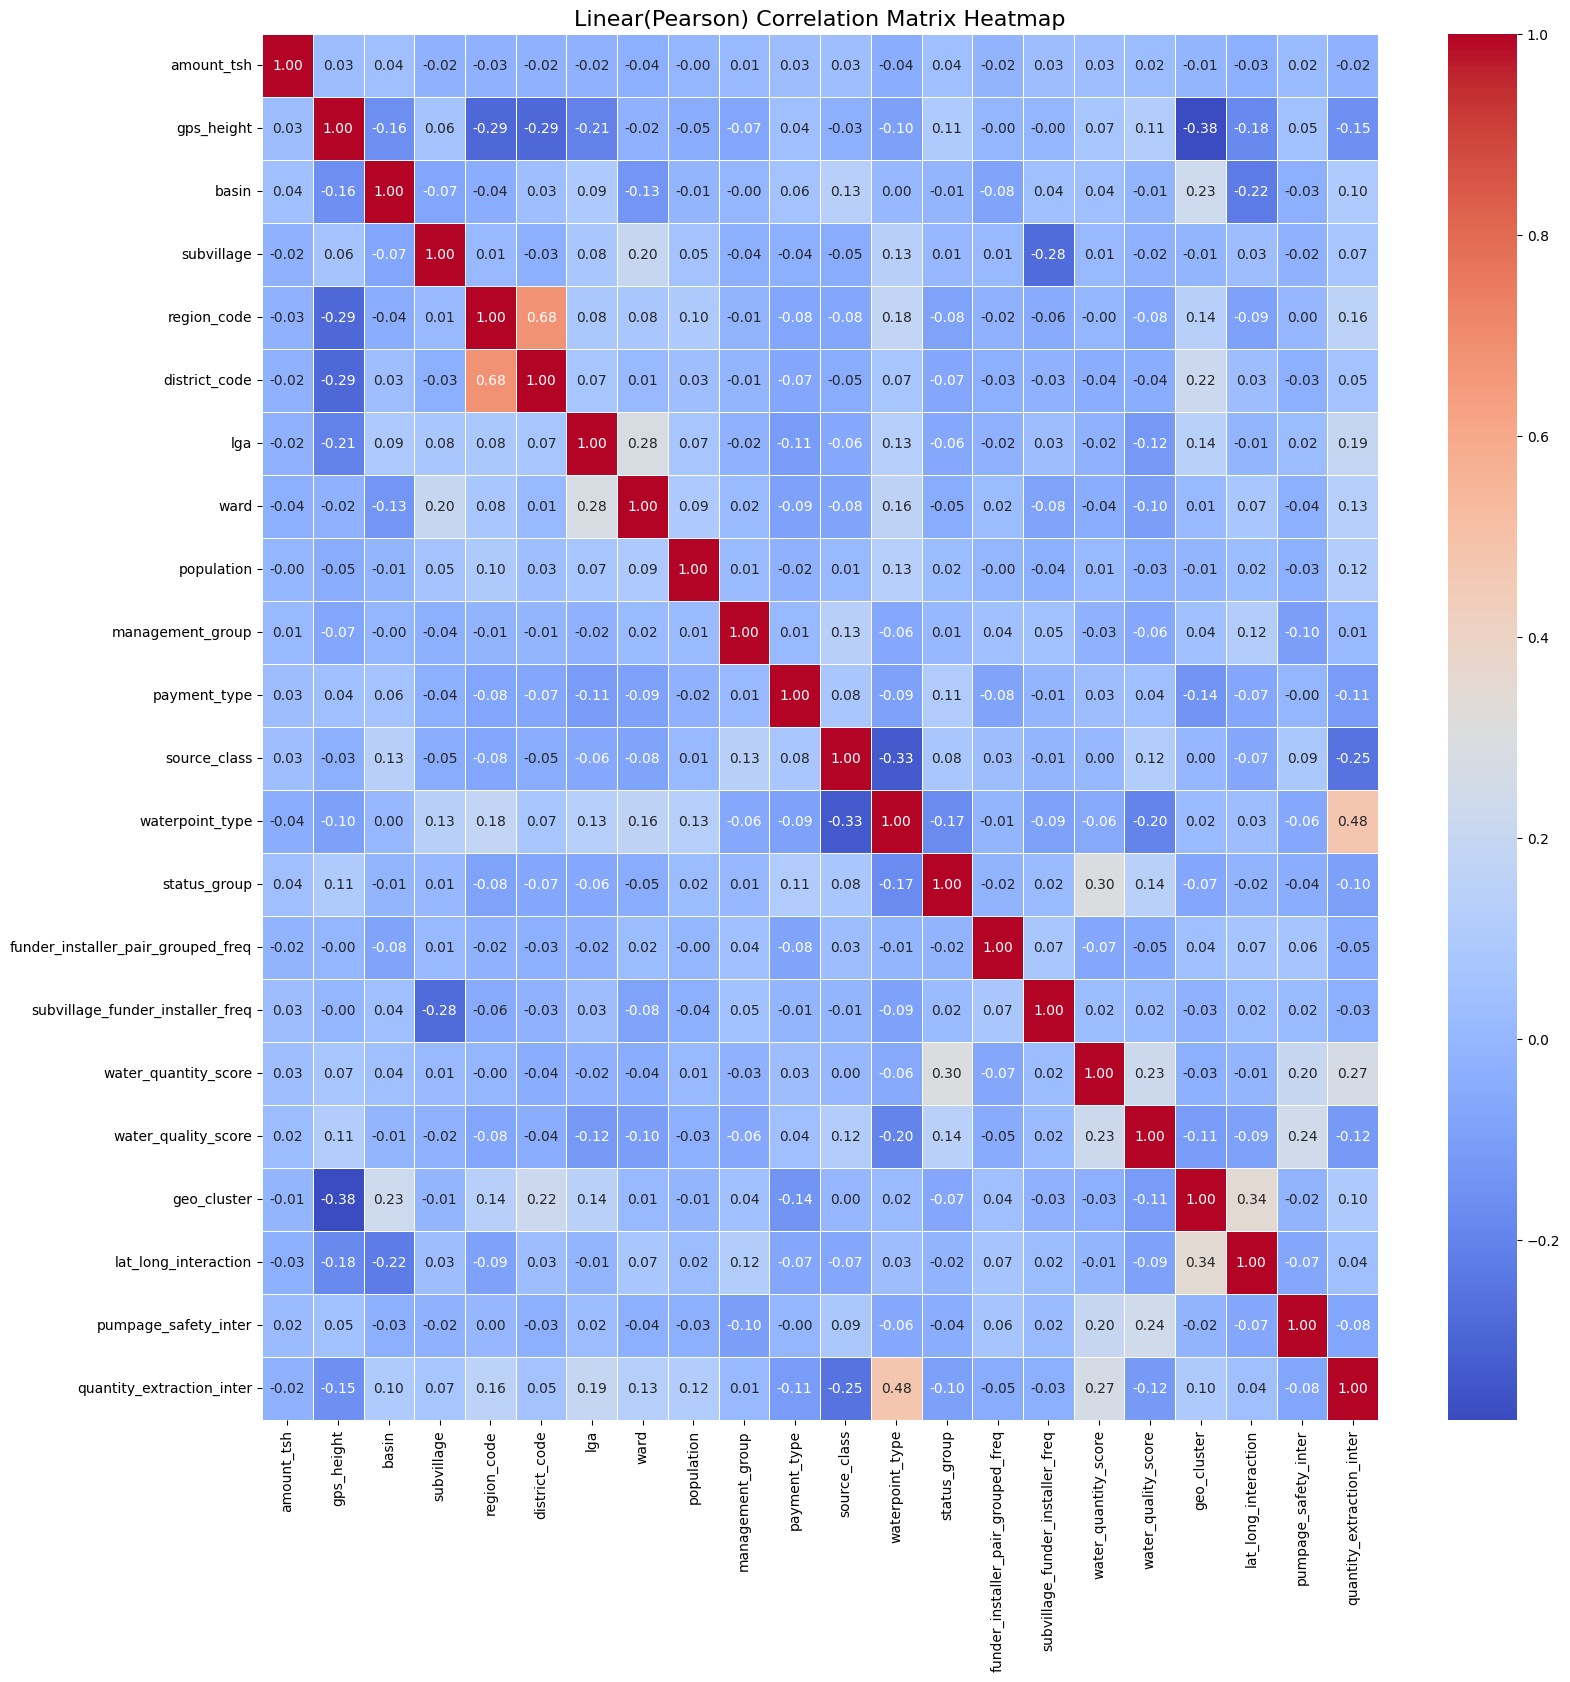

In [35]:
# Recalculate the correlation matrix
correlation_matrix = df.select_dtypes(include='number').corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 18))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Linear(Pearson) Correlation Matrix Heatmap", fontsize=16)

# Show the plot
plt.show()

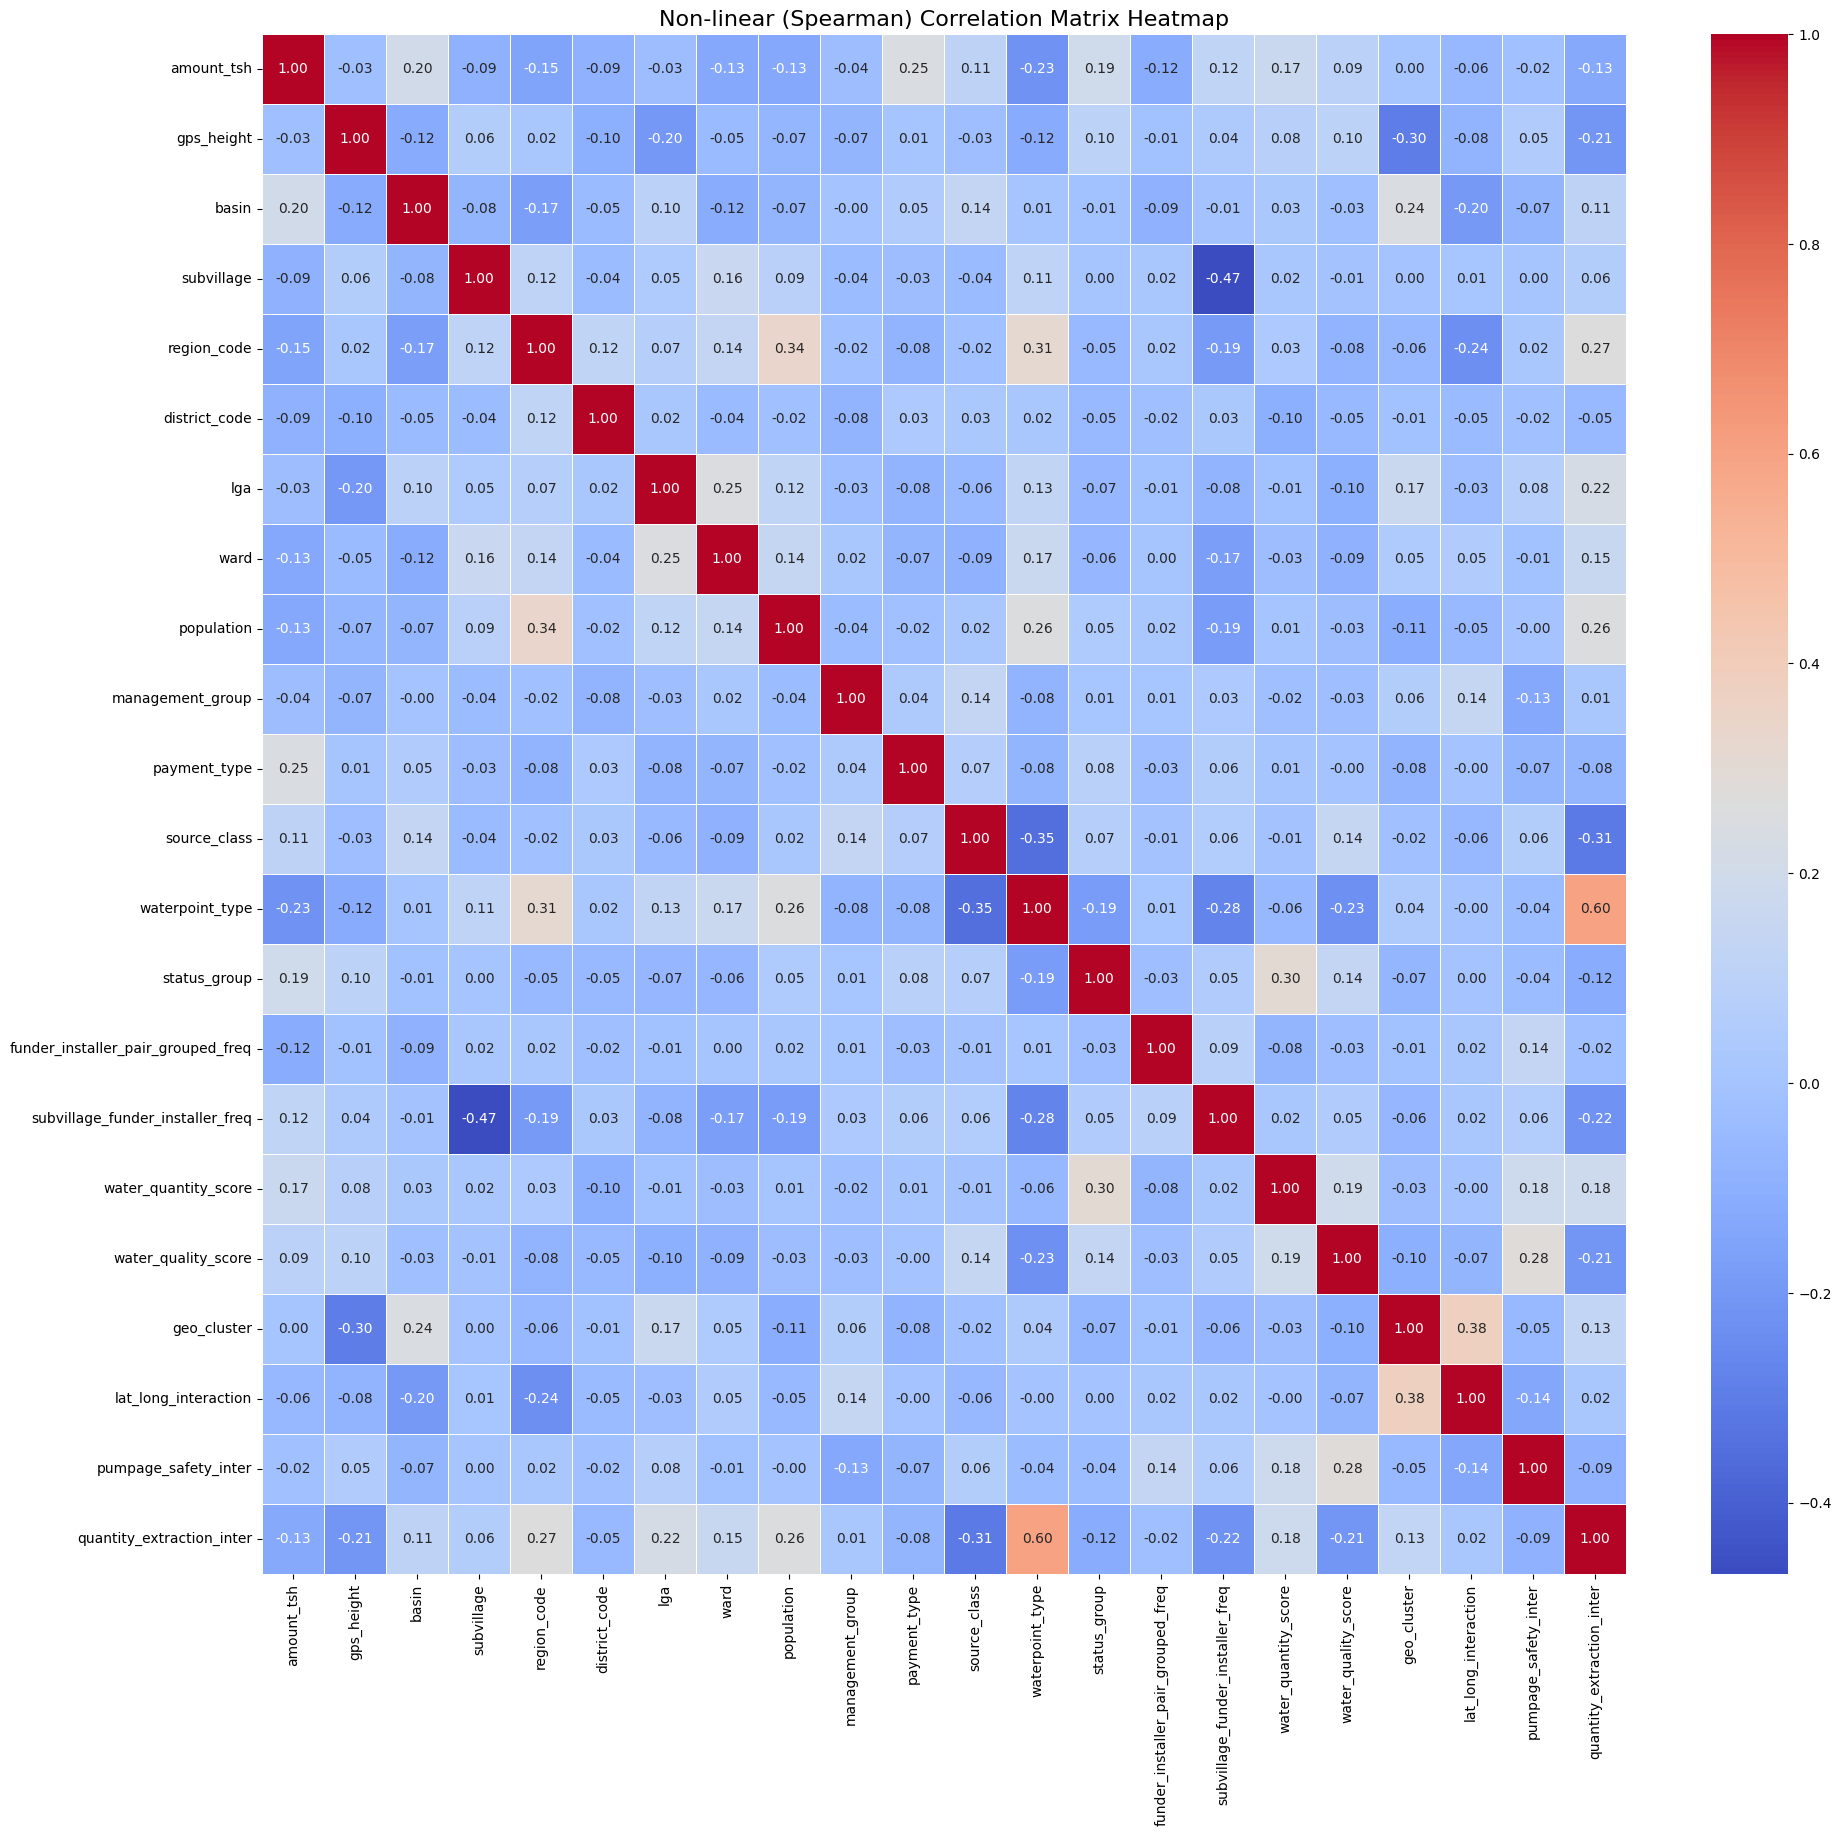

In [36]:
# Recalculate the correlation matrix
correlation_matrix = df.select_dtypes(include='number').corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(22, 20))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Non-linear (Spearman) Correlation Matrix Heatmap", fontsize=16)

# Show the plot
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

pdf = df.copy()

# Replace 0 with NaN
pdf['population'] = pdf['population'].replace(0, pd.NA)

# Drop rows with NaN population for training
train_pdf = pdf.dropna(subset=['population'])


In [13]:
categorical = train_pdf.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical:
    le = LabelEncoder()
    train_pdf[col] = le.fit_transform(train_pdf[col].astype(str))
    label_encoders[col] = le


/var/folders/dy/n44rnxw55t54k5zb19w3gz7m0000gn/T/ipykernel_3878/1227287489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_pdf[col] = le.fit_transform(train_pdf[col].astype(str))
/var/folders/dy/n44rnxw55t54k5zb19w3gz7m0000gn/T/ipykernel_3878/1227287489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_pdf[col] = le.fit_transform(train_pdf[col].astype(str))


In [14]:
X = train_pdf.drop(columns=['population'])
y = train_pdf['population']


In [15]:
# F-regression (ANOVA)
f_scores, p_values = f_regression(X, y)
f_score_series = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)

# Random Forest Feature Importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

In [16]:
# Combine into one DataFrame for comparison
feature_scores = pd.DataFrame({
    'F_score': f_score_series,
    'RF_importance': rf_importances
}).sort_values(by='RF_importance', ascending=False)

print(feature_scores.head(15))


                                       F_score  RF_importance
water_availability_index          13182.087598       0.830406
water_quantity_score                101.936233       0.166607
water_safety_sum                    174.782308       0.001206
funder_grouped                       16.977401       0.000274
district_code                        30.834366       0.000170
gps_height                           12.838089       0.000155
latitude                            137.513362       0.000154
location_bucket                      34.233859       0.000128
basin                                 4.101385       0.000115
ward                                  8.755392       0.000110
amount_tsh                           17.824480       0.000073
lat_long_interaction                982.809683       0.000073
lat_bin                             137.658032       0.000066
subvillage_funder_installer_freq     21.856872       0.000062
longitude                           779.640736       0.000059


In [37]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_mutual_information(df, target_col):
    df_encoded = df.copy()
    
    # Encode categorical columns
    for col in df_encoded.columns:
        if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
            df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))
    
    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]

    # Ensure y is encoded
    if y.dtype == 'object' or y.dtype.name == 'category':
        y = LabelEncoder().fit_transform(y.astype(str))
    
    # Compute mutual information
    mi_scores = mutual_info_classif(X, y, discrete_features='auto')
    
    # Create a DataFrame for easier handling
    mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values(by='MI Score', ascending=False).reset_index(drop=True)
    return mi_df


In [38]:
def plot_mutual_information(mi_df, top_n=20):
    plt.figure(figsize=(10, 8))
    sns.barplot(data=mi_df.head(top_n), x='MI Score', y='Feature', palette='viridis')
    plt.title(f"Top {top_n} Features by Mutual Information with Target")
    plt.tight_layout()
    plt.show()


In [51]:
df.drop(columns=['source_type','source_class'], inplace=True)

/var/folders/dy/n44rnxw55t54k5zb19w3gz7m0000gn/T/ipykernel_3878/93040470.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df.head(top_n), x='MI Score', y='Feature', palette='viridis')


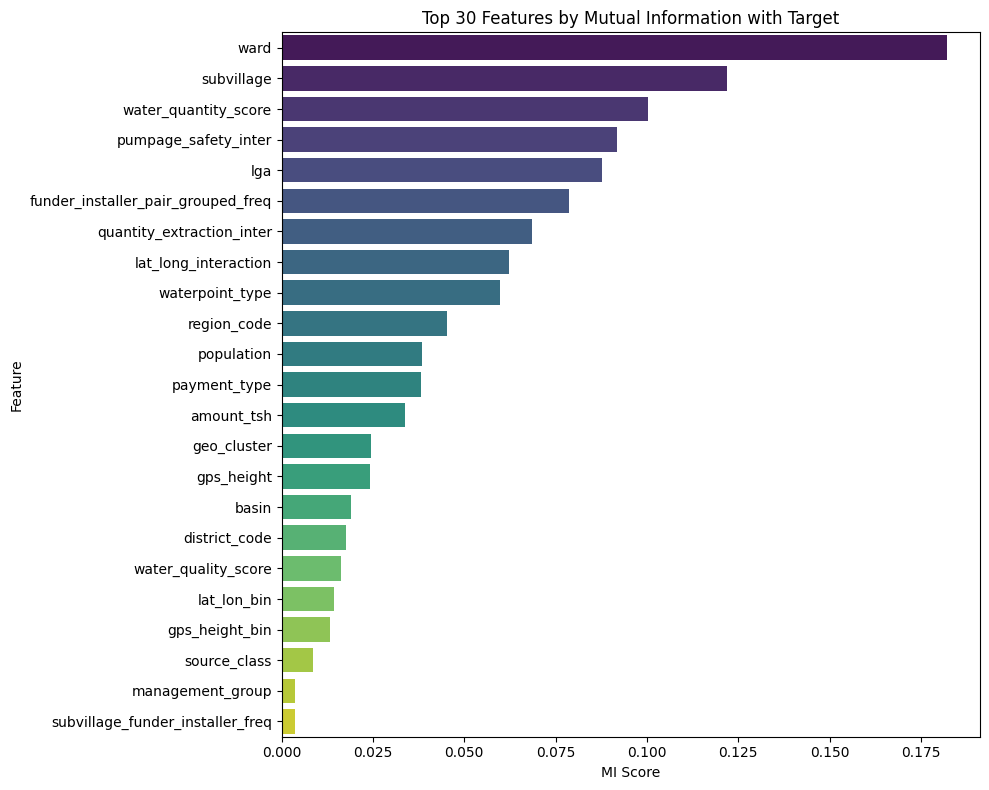

In [39]:
mi_df = compute_mutual_information(df, 'status_group')
plot_mutual_information(mi_df, top_n=30)


In [55]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop('status_group',axis=1)  # Include all features you're evaluating
y = df['status_group']   # This should be label-encoded if it's categorical

# Encode categorical features as needed, and set discrete features manually or use auto
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=0)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print(mi_series.head(30))


ward                             0.183843
subvillage_funder_installer      0.145159
subvillage                       0.120962
funder_installer_pair_grouped    0.117503
quantity_score                   0.109101
installer                        0.100756
water_safety_prod                0.097170
funder                           0.097023
lga                              0.094229
water_safety_sum                 0.086923
longitude                        0.072761
latitude                         0.067071
waterpoint_type                  0.063498
extraction_type                  0.062736
water_availability_index         0.051272
region_code                      0.042275
pump_age                         0.041185
construction_year                0.040881
amount_tsh                       0.035733
payment_type                     0.035396
source                           0.025753
management                       0.019381
gps_height                       0.019003
population                       0

Combining longitude and latitude

In [11]:
from sklearn.cluster import KMeans
import numpy as np

coords = df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=10, random_state=42)
df['geo_cluster'] = kmeans.fit_predict(coords)


In [12]:
df['lat_bin'] = (df['latitude'] * 10).round(0)
df['lon_bin'] = (df['longitude'] * 10).round(0)
df['location_bucket'] = df['lat_bin'].astype(str) + "_" + df['lon_bin'].astype(str)

In [13]:
df['lat_long_interaction'] = df['latitude'] + df['longitude']

In [14]:
# This interaction captures how well an old pump holds up under resource strain.
df['pumpage_wateravail_inter'] = df['pump_age'] * df['water_availability_index']

quantity_score: Measures how much water is available — crucial to functionality.
extraction_type: Defines the mechanism used to get water (handpump, electric, etc.).
These combine to explain mechanical suitability or mismatch, e.g.:
Low quantity + high-demand extraction = likely failure
High quantity + appropriate extraction = success

In [15]:
df['quantity_extraction_class'] = df['water_quantity_score'] * df['extraction_type_class']

In [16]:
df.to_csv("../data/processed/imputed_cleaned_feature_evl.csv", index=False)

In [20]:
# Drop duplicate columns
df.drop(columns=['latitude','longitude','funder','installer','extraction_type_group','source_type','water_safety_prod','location_bucket'], inplace=True)

In [24]:
df.to_csv("../data/processed/imputed_cleandropped_feature_evl.csv", index=False)

In [25]:
df.drop(columns=['extraction_type_class','construction_year','pump_age','water_availability_index','water_safety_sum','lat_bin', 'lon_bin'], inplace=True)
df.shape

(59400, 23)

In [28]:
df.to_csv("../data/processed/clean_cleandropped_feature_evl.csv", index=False)